In [7]:
!pip install seaborn

In [6]:
import copy
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *

#-- Pytorch specific libraries import -----#
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()    
device = "cuda" if torch.cuda.is_available() else "cpu"
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Der Befehl "nvidia-smi" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


False

# Daten für Experimente laden

In [17]:
merged_data_with_g_a = pd.read_csv('student_data_bereinigt_merged.csv') #/kaggle/input/bbdc-2024
merged_data_with_g_a = merged_data_with_g_a.drop([ 'timestamp' , 'sessionId'], axis=1)

C:\Users\tkoehler\AppData\Local\Temp\1\ipykernel_15120\903339299.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data_with_g_a = pd.read_csv('student_data_bereinigt_merged.csv') #/kaggle/input/bbdc-2024


In [19]:
x_data = merged_data_with_g_a.drop(['affect', 'context'], axis=1)
y_data_kontext = merged_data_with_g_a.drop(['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus', 'gender', 'age', 'affect'], axis=1)
y_data_affect = merged_data_with_g_a.drop(['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus', 'gender', 'age', 'context'], axis=1)

## Kontext

In [20]:
X_train, X_test, y_kontext_train, y_kontext_test = train_test_split(x_data, y_data_kontext, random_state=42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

le_k = LabelEncoder()
y_kontext_train = le_k.fit_transform(y_kontext_train)
y_kontext_test = le_k.transform(y_kontext_test)

# Umwandlung in Tensoren
x_train_tensor =  torch.from_numpy(X_train).float()
y_train_tensor =  torch.from_numpy(y_kontext_train.ravel()).long() #.float()
#y_train_tensor = y_train_tensor.unsqueeze(1)
x_test_tensor =  torch.from_numpy(X_test).float()
y_test_tensor =  torch.from_numpy(y_kontext_test.ravel()).long() #.float()
#y_test_tensor = y_test_tensor.unsqueeze(1)

print("\nTrain set Tensors \n")
print(x_train_tensor)
print(y_train_tensor)
print("\nTest set Tensors \n")
print(x_test_tensor)
print(y_test_tensor)

c:\Users\tkoehler\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\tkoehler\AppData\Roaming\pypoetry\venv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



Train set Tensors 

tensor([[ 5.9000e+01,  1.6040e+03,  3.7290e+03,  ...,  0.0000e+00,
          1.0000e+00,  2.0000e+00],
        [-3.7200e+03, -1.0280e+03,  7.0400e+02,  ...,  1.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-3.9840e+03, -5.2400e+02, -5.9000e+02,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        ...,
        [-2.7890e+03, -2.9230e+03,  1.4000e+01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.0650e+03, -3.6580e+03, -1.1130e+03,  ...,  1.0000e+00,
          0.0000e+00,  2.0000e+00],
        [-1.0710e+03, -1.6910e+03, -3.1110e+03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
tensor([4, 4, 4,  ..., 4, 4, 4])

Test set Tensors 

tensor([[-6.6300e+02, -3.0900e+03,  2.5420e+03,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00],
        [-3.4900e+02, -4.4130e+03, -2.7700e+02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.6230e+03, -3.3750e+03,  1.8320e+03,  ...,  0.0000e+00,
          0.0000e+00,

In [28]:
y_kontext_train

array([1, 3, 1, ..., 0, 2, 1])

In [29]:
print(list(le_k.classes_))

['CONVERSATION', 'OTHER', 'VIEW_BOOTH', 'WALKING']


## Optional Daten für Emotionen

In [20]:
X_train, X_test, y_affect_train, y_affect_test = train_test_split(x_data, y_data_affect, random_state=42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

le = LabelEncoder()
y_affect_train = le.fit_transform(y_affect_train)
y_affect_test = le.transform(y_affect_test)

# Umwandlung in Tensoren
x_train_tensor =  torch.from_numpy(X_train).float()
y_train_tensor =  torch.from_numpy(y_affect_train.ravel()).long() #.float()
#y_train_tensor = y_train_tensor.unsqueeze(1)
x_test_tensor =  torch.from_numpy(X_test).float()
y_test_tensor =  torch.from_numpy(y_affect_test.ravel()).long() #.float()
#y_test_tensor = y_test_tensor.unsqueeze(1)

print("\nTrain set Tensors \n")
print(x_train_tensor)
print(y_train_tensor)
print("\nTest set Tensors \n")
print(x_test_tensor)
print(y_test_tensor)

NameError: name 'x_data' is not defined

In [31]:
y_affect_train

array([1, 1, 1, ..., 1, 2, 1])

In [32]:
print(list(le.classes_))

['ANGRY', 'HAPPY', 'RELAXED', 'SAD']


In [7]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
#train_dataloader = DataLoader(train_dataset, batch_size=16)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
#test_dataloader = DataLoader(test_dataset, batch_size=16)

In [9]:
n_input_dim = X_train.shape[1]
n_output = 4

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, 64) #32
        self.layer_2 = nn.Linear(64, 128) #32,64
        self.layer_3 = nn.Linear(128, 128) #64,64
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, n_output) 
        
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64) #32
        self.batchnorm2 = nn.BatchNorm1d(128) #64
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    

model = Model()
print(model)

NameError: name 'X_train' is not defined

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        #print(labels)
        optimizer.zero_grad()

        outputs = model(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        probs = torch.softmax(outputs, dim=-1) #Wahrscheinlichkeit, dass eine bestimmte Ausgabe zu einer bestimmten Klasse gehört
        preds = torch.argmax(probs, 1) 
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [33]:
# ===== https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, tolerance = 5, min_delta = 0.005):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = None #float('inf') #np.Inf

    def early_stopp(self, validation_loss):
        if self.min_validation_loss == None:
            self.min_validation_loss = validation_loss
        elif (self.min_validation_loss - validation_loss) > self.min_delta: 
            self.min_validation_loss = validation_loss
            self.counter=0
        elif (self.min_validation_loss - validation_loss) < self.min_delta: 
            self.counter +=1
            if self.counter >=self.tolerance:
                return True
        return False

def eval_epoch(model, val_loader, criterion, optimizer, epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).long()

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs, dim=-1) #Wahrscheinlichkeit, dass eine bestimmte Ausgabe zu einer bestimmten Klasse gehört
            preds = torch.argmax(probs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    
    return val_loss, val_acc

In [12]:
def train(train_dataset, test_dataset, model, epochs, batch_size, optimizer, criterion):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #test_dataloader = DataLoader(test_dataset, batch_size=16)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer = optimizer
        criterion = criterion
        early_stopper = EarlyStopper()
        best_loss = np.inf

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, test_loader, criterion, optimizer, epoch)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # Speichern das Modell
            if val_loss < best_loss:
                best_loss = val_loss
                experiment_state_dict={
                    'model':model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch,
                }
                torch.save(experiment_state_dict, "/kaggle/working/model_affect.pth")
                print("Das beste Modell ist gespeichert.")
            
            if early_stopper.early_stopp(val_loss):
                print("#########################")
                print("Early stopping triggered!")
                print("#########################")
                break
            
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()#.to(device) #.cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [14]:
model = Model().to(device)
#learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
epochs = 25
history = train(train_dataset, test_dataset, model=model, epochs=epochs, batch_size=64, optimizer = optimizer, criterion = criterion)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 0.8993864361077337


epoch:   4%|▍         | 1/25 [00:57<23:10, 57.94s/it]


Epoch 001 train_loss: 0.8994     val_loss 0.9965 train_acc 0.5567 val_acc 0.5014
Das beste Modell ist gespeichert.
loss 0.8015273177558737


epoch:   8%|▊         | 2/25 [01:55<22:02, 57.49s/it]


Epoch 002 train_loss: 0.8015     val_loss 0.8974 train_acc 0.6217 val_acc 0.5790
Das beste Modell ist gespeichert.
loss 0.7589605343120475


epoch:  12%|█▏        | 3/25 [02:52<21:00, 57.31s/it]


Epoch 003 train_loss: 0.7590     val_loss 0.8654 train_acc 0.6468 val_acc 0.5887
Das beste Modell ist gespeichert.
loss 0.732160214766948


epoch:  16%|█▌        | 4/25 [03:48<19:57, 57.01s/it]


Epoch 004 train_loss: 0.7322     val_loss 0.8351 train_acc 0.6627 val_acc 0.6135
Das beste Modell ist gespeichert.
loss 0.715909419096706


epoch:  20%|██        | 5/25 [04:46<19:02, 57.13s/it]


Epoch 005 train_loss: 0.7159     val_loss 0.8001 train_acc 0.6730 val_acc 0.6291
Das beste Modell ist gespeichert.
loss 0.7027153796155394


epoch:  24%|██▍       | 6/25 [05:43<18:06, 57.20s/it]


Epoch 006 train_loss: 0.7027     val_loss 0.7987 train_acc 0.6803 val_acc 0.6328
Das beste Modell ist gespeichert.
loss 0.6931714326254518


epoch:  28%|██▊       | 7/25 [06:41<17:14, 57.49s/it]


Epoch 007 train_loss: 0.6932     val_loss 0.7967 train_acc 0.6848 val_acc 0.6338
Das beste Modell ist gespeichert.
loss 0.6855398075647836


epoch:  32%|███▏      | 8/25 [07:38<16:16, 57.47s/it]


Epoch 008 train_loss: 0.6855     val_loss 0.7783 train_acc 0.6897 val_acc 0.6436
Das beste Modell ist gespeichert.
loss 0.6799171533713627


epoch:  36%|███▌      | 9/25 [08:36<15:20, 57.54s/it]


Epoch 009 train_loss: 0.6799     val_loss 0.7615 train_acc 0.6924 val_acc 0.6535
Das beste Modell ist gespeichert.
loss 0.674012280901978


epoch:  40%|████      | 10/25 [09:34<14:24, 57.61s/it]


Epoch 010 train_loss: 0.6740     val_loss 0.7870 train_acc 0.6966 val_acc 0.6391
loss 0.6694925606387357


epoch:  44%|████▍     | 11/25 [10:32<13:28, 57.73s/it]


Epoch 011 train_loss: 0.6695     val_loss 0.7416 train_acc 0.6986 val_acc 0.6665
Das beste Modell ist gespeichert.
loss 0.6655426536655171


epoch:  48%|████▊     | 12/25 [11:30<12:30, 57.76s/it]


Epoch 012 train_loss: 0.6655     val_loss 0.7568 train_acc 0.7006 val_acc 0.6482
loss 0.6632037903405023


epoch:  52%|█████▏    | 13/25 [12:28<11:33, 57.81s/it]


Epoch 013 train_loss: 0.6632     val_loss 0.7982 train_acc 0.7018 val_acc 0.6362
loss 0.6593822259472182


epoch:  56%|█████▌    | 14/25 [13:25<10:32, 57.52s/it]


Epoch 014 train_loss: 0.6594     val_loss 0.7638 train_acc 0.7041 val_acc 0.6550
loss 0.6572128382783842


epoch:  60%|██████    | 15/25 [14:22<09:33, 57.36s/it]


Epoch 015 train_loss: 0.6572     val_loss 0.7588 train_acc 0.7052 val_acc 0.6557
loss 0.6551138828300427


epoch:  64%|██████▍   | 16/25 [15:18<08:36, 57.44s/it]


Epoch 016 train_loss: 0.6551     val_loss 0.7581 train_acc 0.7064 val_acc 0.6589
#########################
Early stopping triggered!
#########################


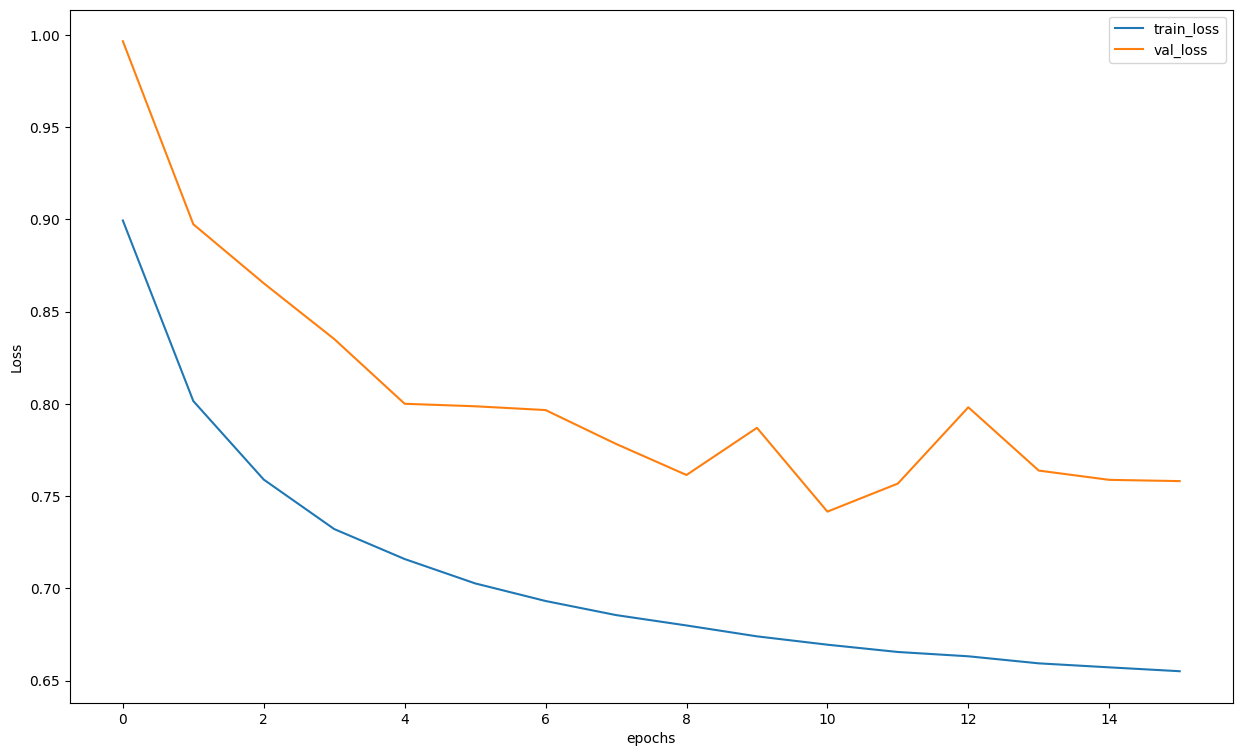

In [15]:
train_loss, train_acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

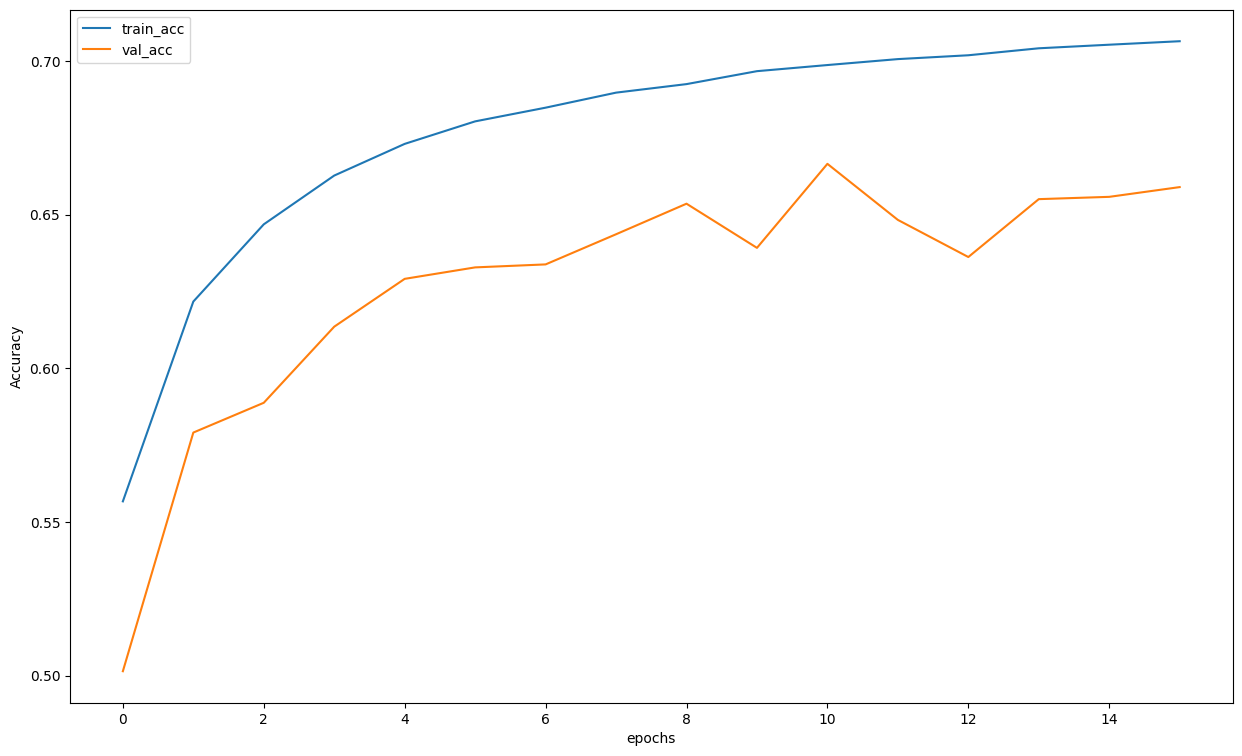

In [16]:
plt.figure(figsize=(15, 9))
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

# Abgabe

In [1]:
import pandas as pd

# Load the data
student_data_path = 'student_data_bereinigt_merged.csv'
student_skeleton_path = 'student_skeleton.csv'

student_data = pd.read_csv(student_data_path)
student_skeleton = pd.read_csv(student_skeleton_path)

C:\Users\tkoehler\AppData\Local\Temp\1\ipykernel_15120\103194577.py:7: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  student_data = pd.read_csv(student_data_path)


In [3]:
import pandas as pd
import numpy as np

def merge_on_closest_timestamp(skeleton, data, timestamp_column='timestamp', session_column='sessionId'):
    # Ensure data is sorted by session and timestamp
    data = data.sort_values(by=[session_column, timestamp_column])
    skeleton = skeleton.sort_values(by=[session_column, timestamp_column])

    # Create an empty DataFrame to store the merged data
    merged_data = pd.DataFrame()

    for session in skeleton[session_column].unique():
        # Filter rows by session
        skeleton_session = skeleton[skeleton[session_column] == session]
        data_session = data[data[session_column] == session]

        if data_session.empty:
            continue

        # Initialize a column to store the closest timestamps from data_session
        skeleton_session['closest_timestamp'] = np.nan

        # Iterate over the skeleton_session DataFrame and find the closest timestamp in data_session
        for index, row in skeleton_session.iterrows():
            skeleton_timestamp = row[timestamp_column]
            
            # Compute the absolute difference between the skeleton timestamp and all data_session timestamps
            abs_diff = data_session[timestamp_column].sub(skeleton_timestamp).abs()
            
            # Find the index of the minimum difference
            closest_idx = abs_diff.idxmin()

            # Store the closest timestamp in the skeleton_session DataFrame
            skeleton_session.at[index, 'closest_timestamp'] = data_session.loc[closest_idx, timestamp_column]

        # Merge the skeleton_session DataFrame with the data_session DataFrame based on the closest timestamp
        merged_session = pd.merge(skeleton_session, data_session, how='left', left_on=['sessionId', 'closest_timestamp'], right_on=[session_column, timestamp_column])

        # Append the merged_session DataFrame to the merged_data DataFrame
        merged_data = pd.concat([merged_data, merged_session])

    # Drop the 'closest_timestamp' column if no longer needed
    merged_data.drop(columns=['closest_timestamp', 'affect_x', 'context_x', 'affect_y', 'context_y'], inplace=True)
    
    return merged_data

merged_data = merge_on_closest_timestamp(student_skeleton, student_data)



C:\Users\tkoehler\AppData\Local\Temp\1\ipykernel_15120\3807845671.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skeleton_session['closest_timestamp'] = np.nan
C:\Users\tkoehler\AppData\Local\Temp\1\ipykernel_15120\3807845671.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skeleton_session['closest_timestamp'] = np.nan
C:\Users\tkoehler\AppData\Local\Temp\1\ipykernel_15120\3807845671.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [4]:
features_for_prediction = ['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus','gender','age']
X_for_prediction = merged_data[features_for_prediction]

In [10]:
# Convert the DataFrame to a NumPy array
X_for_prediction_np = X_for_prediction.to_numpy()

x_abgabe_kontext_tensor =  torch.from_numpy(X_for_prediction_np).float()
x_abgabe_kontext_dataset = TensorDataset(x_abgabe_kontext_tensor)
x_abgabe_kontext_dataloader = DataLoader(x_abgabe_kontext_dataset, batch_size = 64,  shuffle=False)

In [21]:
n_input_dim = X_train.shape[1]
n_output = 4

class Model_CNN(nn.Module):
    def __init__(self):
        super(Model_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_output)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = self.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model_cnn = Model_CNN()
print(model_cnn)


Model_CNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [31]:
model_affect = Model_CNN().to(device)
optimizer = torch.optim.AdamW(model_affect.parameters())
criterion = nn.CrossEntropyLoss()

#model_affect.load_state_dict(torch.load("model_cnn_kontext_epoch33.pth")['model'])

model = Model_CNN().to(device)


# Load the model weights
model_path = 'model_cnn_affect_epoch48.pth'  # Update path as necessary

# Load the entire checkpoint
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# Assuming the model's state_dict is stored under 'model' key in the checkpoint
model.load_state_dict(checkpoint['model'])

#ausgabe_affect = predict(model_affect)

<All keys matched successfully>

In [11]:
model = Model().to(device)

# Load the model weights
model_path = 'model_cnn_kontext_epoch33.pth'  # Update path as necessary

# Load the entire checkpoint
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# Assuming the model's state_dict is stored under 'model' key in the checkpoint
model.load_state_dict(checkpoint['model'])

# Set the model to evaluation mode
model.eval()

NameError: name 'Model' is not defined

In [32]:
def predict(model, test_loader, device='cpu'):
    with torch.no_grad():
        logits = []
    
        for inputs_tuple in test_loader:
            # Assuming the DataLoader returns a tuple, we extract the first element (tensor) here
            inputs = inputs_tuple[0].to(device)
            model.eval()
            outputs = model(inputs).cpu()  # Move the outputs to CPU for further operations
            logits.append(outputs)
            
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=1)  # Use axis=1 for consistency
    return preds

# Before calling predict, ensure 'device' is defined, e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# And ensure the model and the data are moved to the correct device
model.to(device)

# Now, you can call your predict function
predictions = predict(model, x_abgabe_kontext_dataloader, device)


In [30]:
predictions_kontext = predictions

In [33]:
predictions_affect = predictions

In [34]:
class_mapping_affect = {
    0: "ANGRY",
    1: "HAPPY",
    2: "RELAXED",
    3: "SAD"
}

predictions_affect_mapped = [class_mapping_affect[x] for x in predictions_affect]

class_mapping_context = {
    0: "CONVERSATION",
    1: "OTHER",
    2: "VIEW_BOTH",
    3: "WALKING"
}

predictions_context_mapped = [class_mapping_context[x] for x in predictions_kontext]

In [35]:
# For seperate context and affect
student_skeleton_prediction = student_skeleton
student_skeleton_prediction['context'] = predictions_context_mapped
student_skeleton_prediction['affect'] = predictions_affect_mapped

#Change name of file here!
student_skeleton_prediction.to_csv('prediction_NeuralNetwork_CNN_01.csv', index=False)


In [9]:
# Daten hochladen und für das Modell vorbereiten

merged_data_with_g_a = pd.read_csv('merged_preprocessed_data_with_info_numericSamples.csv') # Path anpassen
X_abgabe_kontext = merged_data_with_g_a.drop(['notification', 'engagement', 'timestamp' , 'sessionId', 'timestamp_seconds'], axis=1) #Wenn nötig, etwas droppen

#x_data = merged_data_with_g_a.drop(['affect', 'context'], axis=1)
#y_data_kontext = merged_data_with_g_a.drop(['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus', 'gender', 'age', 'affect'], axis=1)
#y_data_affect = merged_data_with_g_a.drop(['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus', 'gender', 'age', 'context'], axis=1)

X_abgabe_kontext = X_abgabe_kontext.to_numpy()
#X_abgabe_affect = X_abgabe_affect.to_numpy()

#le = LabelEncoder()
#y_affect_train = le.fit_transform(y_affect_train)
#y_affect_test = le.transform(y_affect_test)

# Umwandlung in Tensoren
x_abgabe_kontext_tensor =  torch.from_numpy(X_abgabe_kontext).float()
#y_train_tensor =  torch.from_numpy(y_affect_train.ravel()).long() #.float()
#x_abgabe_affect_tensor =  torch.from_numpy(X_abgabe_affect).float()
#y_test_tensor =  torch.from_numpy(y_affect_test.ravel()).long() #.float()


print("\nTrain set Tensors \n")
print(x_abgabe_kontext_tensor)
print("\nTest set Tensors \n")
#print(x_abgabe_affect_tensor)

x_abgabe_kontext_dataset = TensorDataset(x_abgabe_kontext_tensor)
x_abgabe_kontext_dataloader = DataLoader(x_abgabe_kontext_dataset, batch_size = 64,  shuffle=False)

#x_abgabe_affect_dataset = TensorDataset(x_abgabe_affect_tensor)
#x_abgabe_affect_dataloader = DataLoader(x_abgabe_affect_dataset, batch_size = 64,  shuffle=False)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [32]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu() #.to(device) #.cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = np.argmax(probs, 1)
    return preds
#probs = torch.softmax(outputs, dim=-1) #Wahrscheinlichkeit, dass eine bestimmte Ausgabe zu einer bestimmten Klasse gehört
#preds = torch.argmax(probs, 1)

## Vorhersage für Kontext

In [ ]:
model_kontext = Model().to(device)
optimizer = torch.optim.AdamW(model_kontext.parameters())
criterion = nn.CrossEntropyLoss()

torch.save(model_kontext.state_dict(), "path_to\\model_kontext_5Schicten64x128_b64_earlyStop14aus25.pth") 

ausgabe_kontext = predict(model_kontext)

## Vorhersage für Emotionen

In [ ]:
model_affect = Model().to(device)
optimizer = torch.optim.AdamW(model_affect.parameters())
criterion = nn.CrossEntropyLoss()

torch.save(model_affect.state_dict(), "path_to\\model_affect_5Schichten_64x128_b64_earlyStop16aus25.pth") 

ausgabe_affect = predict(model_affect)